In [1]:
import warnings

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn import metrics, model_selection, pipeline
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
from typing import Any, Dict, Sequence


def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.
    Parameters
    ----------
    trial : List[Dict[str, Any]]
    A list of trial dictionaries.
    Returns
    -------
    pd.DataFrame
    A DataFrame with columns for the loss, trial id, and
    values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k: (v[0] if isinstance(v, list) else v)
               for k, v in misc['vals'].items()
               }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [3]:
import json

# Loading the dictionary from the file
with open('../data/engineering/constraints/interaction_constraints.json', 'r') as file:
    interaction_constraints = json.load(file)

print(interaction_constraints)

# Load from file
with open('../data/engineering/constraints/monotone_constraints_dict.json', 'r') as file:
    monotone_constraints_dict = json.load(file)

print(monotone_constraints_dict)

[['points_home', 'points_away', 'stage', 'home_streak_wins', 'away_streak_wins']]
{'diff_avg_rating_attack': 1, 'home_streak_wins': 1}


In [4]:
X_train = pd.read_csv('../data/engineering/X_train.csv')
X_val = pd.read_csv('../data/engineering/X_val.csv')
X_test = pd.read_csv('../data/engineering/X_test.csv')

y_train = pd.read_csv('../data/engineering/y_train.csv')
y_val = pd.read_csv('../data/engineering/y_val.csv')
y_test = pd.read_csv('../data/engineering/y_test.csv')

In [5]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2432, 28)
X_val shape: (608, 28)
X_test shape: (3039, 28)
y_train shape: (2432, 1)
y_val shape: (608, 1)
y_test shape: (3039, 1)


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   stage                         2432 non-null   float64
 1   ewm_home_team_goals           2432 non-null   float64
 2   ewm_away_team_goals           2432 non-null   float64
 3   ewm_home_team_goals_conceded  2432 non-null   float64
 4   ewm_away_team_goals_conceded  2432 non-null   float64
 5   points_home                   2432 non-null   float64
 6   points_away                   2432 non-null   float64
 7   home_weighted_wins            2432 non-null   float64
 8   away_weighted_wins            2432 non-null   float64
 9   avg_home_team_rating          2432 non-null   float64
 10  avg_away_team_rating          2432 non-null   float64
 11  home_streak_wins              2432 non-null   float64
 12  away_streak_wins              2432 non-null   float64
 13  ewm

In [7]:
X_tst = X_test.loc[:600]
y_tst = y_test[:600]

In [8]:
cfl = xgb.XGBClassifier(random_state=42, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict)

cfl.fit(X_train, y_train)
y_pred = cfl.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Accuracy score: {cfl.score(X_val, y_val)}')

F1 score: 0.503520283476352
Accuracy score: 0.5148026315789473


In [9]:
# Let's try w/ depth of 2 and 2 trees
cfl2 = xgb.XGBClassifier(max_depth=2, n_estimators=2, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict)

cfl2.fit(X_train, y_train)
y_pred = cfl2.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Score: {cfl2.score(X_val, y_val)}')

F1 score: 0.4479649752474825
Score: 0.524671052631579


In [10]:
xg_1 = xgb.XGBClassifier(
    early_stopping_rounds=30,
    interaction_constraints=interaction_constraints, 
    monotone_constraints=monotone_constraints_dict
)
xg_1.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_val, y_val)],
         verbose=0
       )

y_pred = xg_1.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Score: {xg_1.score(X_val, y_val)}')

F1 score: 0.46168091797269845
Score: 0.53125


In [11]:
# One convention
# is that hyperparameters that start with max_ will tend to complicate the model (and lead to
# overfitting) when you raise the value. Conversely, they will simplify the model if you lower
# them (and lead to underfitting). Often there is a sweet spot in between

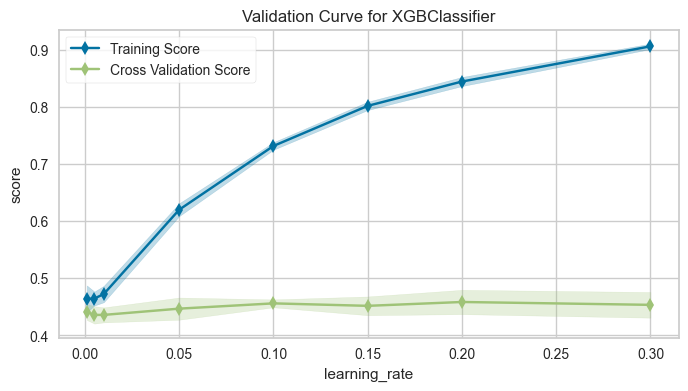

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,...
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan,
                                        monotone_constraints={'diff_avg_rating_attack': 1,
                                                              'home_streak_wins': 1},
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=42, ...),
                n_jobs=-1, param_name='learning_rate',
                param_range=array([0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.15 , 0.2  , 0.3  ]),
                scoring='f1_weighted')

In [12]:
from yellowbrick import model_selection as ms

fig, ax = plt.subplots(figsize=(8, 4))
# ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma',
#                     param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax, scoring="f1_weighted")

ms.validation_curve(xgb.XGBClassifier(random_state=42, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict), X_train, y_train, param_name='learning_rate',
                    param_range=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3], n_jobs=-1, ax=ax, scoring="f1_weighted")

# This validation curve poses two possibilities: first, 
# that we do not have the correct param_range to find the best k and need to expand our search to larger values. 
# The second is that other hyperparameters (such as uniform or distance based weighting, or even the distance metric)
# may have more influence on the default model than k by itself does.
# Although validation curves can give us some intuition about the performance of a model to a single hyperparameter, 
# grid search is required to understand the performance of a model with respect to multiple hyperparameters.

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union


def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series,
                          early_stopping_rounds: int = 50,
                          metric: callable = accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value is 50.
    metric : callable
        Metric to maximize. Default is accuracy
        Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """

    int_vals = ['max_depth']
    space = {k: (int(val) if k in int_vals else val)
             for k, val in space.items()}
    # space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict)
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred, average='weighted').round(3)
    return {'loss': 1-score, 'status': STATUS_OK, 'model': model}


(array([ 967.,  910., 1063.,  920., 1036., 1040., 1007., 1001., 1004.,
        1052.]),
 array([2.00040556, 2.80028638, 3.6001672 , 4.40004802, 5.19992884,
        5.99980966, 6.79969048, 7.5995713 , 8.39945212, 9.19933294,
        9.99921376]),
 <BarContainer object of 10 artists>)

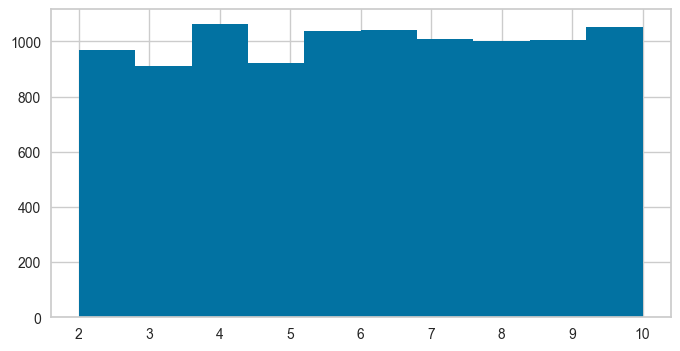

In [19]:
from hyperopt import hp, pyll
# hp.loguniform('min_child_weight', -1, 3)
uniform_vals = [pyll.stochastic.sample(hp.uniform('value', 2, 10))
                for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)

In [20]:
options_learning_rate = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0)
    # Best Hyperparameters: {'learning_rate': 0.1640487517918771}
}

options = {
    'eta': hp.uniform('eta', 0.01, 0.3),  # Default is 0.3, so we search around it
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7]),  # Default is 6, so we stay close
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),  # Default is 1, we allow it to go up
    'gamma': hp.uniform('gamma', 0, 5),  # Default is 0, but we explore a range up to 5
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Default is 1, we explore down to 0.5
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Default is 1, we explore down to 0.5
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # Default is 0, exploring up to 1 for L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 1, 3),  # Default is 1, exploring up to 3 for L2 regularization
    'n_estimators': hp.choice('n_estimators', [100, 150, 200, 300, 400])  # Default is 100, exploring up to 400
}


trials = Trials()

best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val, 20, f1_score), space=options,
            algo=tpe.suggest,
            max_evals=300, 
            trials=trials)

print("Best Hyperparameters:", best)

100%|██████████| 300/300 [26:41<00:00,  5.34s/trial, best loss: 0.498]
Best Hyperparameters: {'colsample_bytree': 0.9114465369377368, 'eta': 0.16147449496040192, 'gamma': 2.080778696764677, 'max_depth': 2, 'min_child_weight': 4.013207693370999, 'n_estimators': 3, 'reg_alpha': 0.12925089382194327, 'reg_lambda': 2.7044947662745638, 'subsample': 0.6238518201997677}


In [ ]:
300/300 [07:58<00:00,  1.60s/trial, best loss: 0.497]           
Best Hyperparameters: {'colsample_bytree': 0.556163857931663, 'eta': 0.20561726183794185, 'gamma': 3.0850092179234103, 'max_depth': 3, 'min_child_weight': 7.321877129585404, 'n_estimators': 3, 'reg_alpha': 0.6852638854655516, 'reg_lambda': 2.95358359982023, 'subsample': 0.5788833838654643}

In [ ]:
100%|██████████| 300/300 [26:41<00:00,  5.34s/trial, best loss: 0.498]
Best Hyperparameters: {'colsample_bytree': 0.9114465369377368, 'eta': 0.16147449496040192, 'gamma': 2.080778696764677, 'max_depth': 2, 'min_child_weight': 4.013207693370999, 'n_estimators': 3, 'reg_alpha': 0.12925089382194327, 'reg_lambda': 2.7044947662745638, 'subsample': 0.6238518201997677}

In [17]:
hyper2hr = trial2df(trials)

In [18]:
hyper2hr

,learning_rate,loss,tid
0,0.154148,0.549,0
1,0.164327,0.546,1
2,0.053528,0.552,2
3,0.072665,0.553,3
4,0.506297,0.541,4
...,...,...,...
295,0.920591,0.549,295
296,0.337281,0.549,296
297,0.744573,0.546,297
298,0.984027,0.543,298


In [19]:
import seaborn as sns
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.heatmap(hyper2hr.corr(method='pearson'),
#             cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
#            )

(hyper2hr
 .corr(method='pearson')
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

,learning_rate,loss,tid
learning_rate,1.000000,-0.479609,0.363266
loss,-0.479609,1.000000,-0.212700
tid,0.363266,-0.212700,1.000000


In [44]:
params = {'random_state': 42}
rounds = [
        # Group 0: Tree complexity parameters
    {
        'gamma': hp.uniform('gamma', 5, 7.5),
        'min_child_weight': hp.uniform('min_child_weight', 2, 10),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.75, 0.8),
        'subsample': hp.uniform('subsample', 0.6, 0.95),
        'reg_alpha': hp.uniform('reg_alpha', 2.5, 3.1),
        'reg_lambda': hp.uniform('reg_lambda', 2.5, 5),
        'eta': hp.loguniform('eta', np.log(0.001), np.log(0.05)),
        'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'n_estimators': hp.choice('n_estimators', np.arange(100, 401, 50))
        
    },
    
    # Group 4: Boosting parameter
    {'min_child_weight':hp.quniform('min_child_weight', 0, 10, 1),
     'reg_lambda': hp.uniform('reg_lambda', 4, 10),
     'reg_alpha': hp.uniform('reg_alpha', 0.25, 0.8),
     'eta':hp.uniform('eta',0.001,0.35),
     'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
     'n_estimators': hp.choice('n_estimators', np.arange(100, 401, 50))
    },
]

In [45]:
all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val, 120, f1_score), 
                space=params,
                algo=tpe.suggest,
                max_evals=150,
                trials=trials,
                )
    params = {**params, **best}
    all_trials.append(trials)

100%|██████████| 3000/3000 [40:39<00:00,  1.23trial/s, best loss: -0.475]  


In [54]:
trial2df(all_trials[1]).sort_values(by='loss', ascending=True).head(10)

,eta,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,loss,tid
1756,0.281610,5,8.0,6,0.503087,6.659802,-0.475,1756
2493,0.281409,3,8.0,4,0.554510,6.430027,-0.475,2493
2742,0.280661,5,7.0,4,0.618313,6.605804,-0.475,2742
1119,0.280888,6,7.0,4,0.566367,6.698345,-0.475,1119
2544,0.281390,3,8.0,5,0.539164,6.574923,-0.475,2544
2734,0.280833,5,7.0,4,0.620104,6.586526,-0.475,2734
1477,0.281588,1,7.0,6,0.503753,6.573440,-0.475,1477
2754,0.281705,5,7.0,4,0.619773,6.682221,-0.475,2754
2787,0.281071,5,7.0,4,0.636961,6.815008,-0.475,2787
2008,0.281103,6,7.0,4,0.622525,6.820363,-0.475,2008


In [55]:
trial2df(all_trials[0]).sort_values(by='loss', ascending=True).head(10)

,colsample_bytree,eta,gamma,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss,tid
2714,0.792708,0.049856,5.080196,3,7.305041,6,2.692825,4.807767,0.740603,-0.469,2714
1299,0.786787,0.049719,5.040218,3,7.015879,6,2.814867,3.626806,0.734030,-0.468,1299
2421,0.788652,0.049820,5.046467,3,7.103765,6,2.710298,4.566820,0.740694,-0.468,2421
2706,0.790571,0.049992,5.089498,3,7.090604,6,2.712268,4.755041,0.739311,-0.468,2706
2307,0.786837,0.049792,5.003934,3,7.077635,6,2.763858,4.774087,0.742385,-0.468,2307
2580,0.792624,0.049934,5.095664,3,7.205648,6,2.791328,4.799587,0.741191,-0.467,2580
2856,0.786807,0.049697,5.139260,4,6.435072,6,2.727435,4.662000,0.737454,-0.467,2856
2183,0.788303,0.049896,5.096740,3,6.835829,6,2.799354,4.958475,0.741550,-0.467,2183
2841,0.789165,0.049673,5.081890,3,6.455899,6,2.751901,4.817656,0.739766,-0.467,2841
2318,0.786370,0.049815,5.041711,3,7.172593,6,2.728805,4.614054,0.741569,-0.467,2318


In [57]:
space_1 = {
    'eta': 0.281610,
    'max_depth': 5,
    'min_child_weight': 8.0,
    'n_estimators': 350,
    'reg_alpha': 0.503,
    'reg_lambda': 6.65
}

space_2 = {
    'eta': 0.0049,
    'max_depth': 3,
    'min_child_weight': 7.305,
    'n_estimators': 100, # 350
    'reg_alpha': 2.692, # 2.78
    'reg_lambda': 4.4807, # 4.97
    'subsample': 0.74,
    'colsample_bytree': 0.792,
    'gamma': 5.08,
}

In [22]:
best_hyperparameters_1 = {
    'colsample_bytree': 0.7402689253639231,
    'gamma': 0.0028348541499777537,
    'learning_rate': 0.1752060870921795,
    'max_depth': 6,
    'min_child_weight': 3.0532978217490725,
    'reg_alpha': 4.390442958079982,
    'reg_lambda': 5.821841964093785,
    'subsample': 0.68327049590758
}

best_hyperparameters_2 = {
    'colsample_bytree': 0.7692485988189818,
    'gamma': 0.00012070096616614979,
    'learning_rate': 0.001554370091231591,
    'max_depth': 12,
    'min_child_weight': 1.0584548941145138,
    'reg_alpha': 0.0029253070004006676,
    'reg_lambda': 6.230782615668019,
    'subsample': 0.9619535988644129
}

best_hyperparameters_3 = {
    'colsample_bytree': 0.9206694651571061,
    'gamma': 0.00042191775548186306,
    'learning_rate': 0.3948078011409823,
    'max_depth': 6,
    'min_child_weight': 4.239951535915615,
    'reg_alpha': 9.331451879784092,
    'reg_lambda': 9.243205902587139,
    'subsample': 0.9487693920624407
}

best_hyperparameters_4 = {
    'colsample_bylevel': 0.8596697702529492,
    'colsample_bytree': 0.8702259620796213,
    'eta': 0.13283991319433858,
    'gamma': 0.1947909337094635,
    'max_depth': 2,
    'min_child_weight': 2.0,
    'n_estimators': 100,
    'subsample': 0.7835483934165692
}

max_depth_values = np.arange(8, 18, 1, dtype=int)
actual_max_depth_value = max_depth_values[best_hyperparameters_4['max_depth']]

# Now replace the index with the actual value
best_hyperparameters_4['max_depth'] = actual_max_depth_value

In [11]:
best_hyperparameters_5 = {
    'colsample_bytree': 0.7,
    'gamma': 5,
    'learning_rate': 0.001554370091231591,
    'max_depth': 6,
    'min_child_weight': 4,
    'reg_alpha': 3,
    'reg_lambda': 6,
    'subsample': 0.7,
    'n_estimators': 300
}

In [69]:
space_1 = {
    'eta': 0.281610,
    'max_depth': 5,
    'min_child_weight': 8.0,
    'n_estimators': 350,
    'reg_alpha': 0.503,
    'reg_lambda': 6.65
}

space_2 = {
    'eta': 0.0049,
    'max_depth': 3,
    'min_child_weight': 7.305,
    'n_estimators': 100, # 350
    'reg_alpha': 2.692, # 2.78
    'reg_lambda': 4.4807, # 4.97
    'subsample': 0.74,
    'colsample_bytree': 0.792,
    'gamma': 5.08,
}

In [35]:
space_1 = {
    'colsample_bytree': 0.556163857931663,
    'eta': 0.20561726183794185,
    'gamma': 3.0850092179234103,
    'max_depth': 3,
    'min_child_weight': 7.321877129585404,
    'n_estimators': 100,
    'reg_alpha': 0.6852638854655516,
    'reg_lambda': 2.95358359982023,
    'subsample': 0.5788833838654643
}

In [36]:
xg_ex = xgb.XGBClassifier(**space_1, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict)
xg_ex.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
xg_ex.score(X_val, y_val)

y_pred=xg_ex.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Score: {cfl.score(X_val, y_val)}')

[0]	validation_0-mlogloss:1.07391	validation_1-mlogloss:1.07004
[99]	validation_0-mlogloss:0.93490	validation_1-mlogloss:0.97075
F1 score: 0.5021152182819089
Score: 0.5148026315789473


In [74]:
xg_ex = xgb.XGBClassifier(**space_2, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict)
xg_ex.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
xg_ex.score(X_val, y_val)

y_pred=xg_ex.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Score: {cfl.score(X_val, y_val)}')

[0]	validation_0-mlogloss:1.09802	validation_1-mlogloss:1.09824
[99]	validation_0-mlogloss:1.04769	validation_1-mlogloss:1.04685
F1 score: 0.4374537292925651
Score: 0.5148026315789473


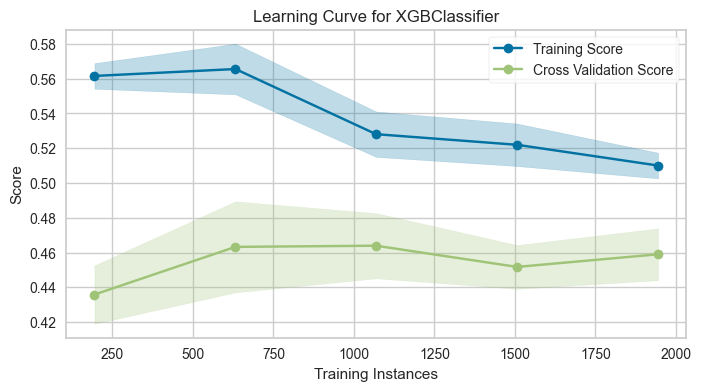

(0.6, 1.0)

In [37]:
import yellowbrick.model_selection as ms

fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**space_1, interaction_constraints=interaction_constraints, monotone_constraints=monotone_constraints_dict), X_train, y_train, ax=ax, scoring="f1_weighted")
ax.set_ylim(0.6, 1)

In [12]:
round(y_train.value_counts(normalize=True) * 100, 2)

result_match
2               45.44
0               28.70
1               25.86
Name: proportion, dtype: float64